In [2]:
from fastai.vision.all import *

In [9]:
from pathlib import Path

path = Path('data/cnn')
path.absolute()

Path('/home/jkim/udemy/deep-learning/data/cnn')

In [10]:
files = get_image_files(path / 'training_set')
files

(#8000) [Path('data/cnn/training_set/cats/cat.3631.jpg'),Path('data/cnn/training_set/cats/cat.1070.jpg'),Path('data/cnn/training_set/cats/cat.441.jpg'),Path('data/cnn/training_set/cats/cat.1608.jpg'),Path('data/cnn/training_set/cats/cat.3552.jpg'),Path('data/cnn/training_set/cats/cat.468.jpg'),Path('data/cnn/training_set/cats/cat.1473.jpg'),Path('data/cnn/training_set/cats/cat.1172.jpg'),Path('data/cnn/training_set/cats/cat.3966.jpg'),Path('data/cnn/training_set/cats/cat.2841.jpg')...]

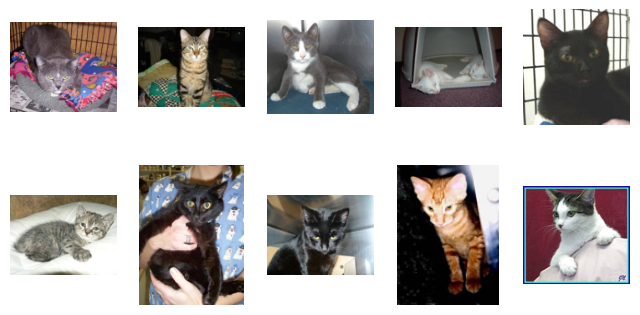

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4))

for i, ax in enumerate(axs.flat):
    ax.axis('off')
    ax.imshow(PILImage.create(files[i]).to_thumb(128))

In [12]:
img = PILImage.create(files[0])
img.size

(350, 294)

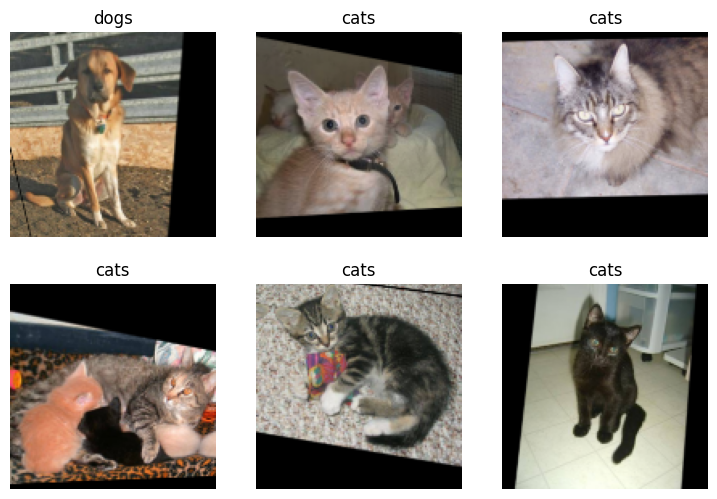

In [132]:
dls = ImageDataLoaders.from_folder(
    path / 'training_set',
    valid_pct=0.2,
    bs=64,
    item_tfms=Resize((256, 256), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    batch_tfms=aug_transforms(size=(128, 128), min_scale=0.75)
)

dls.show_batch(max_n=6)

In [133]:
# [t.shape for t in next(iter(dls.train))]
x, y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64]))

In [134]:
def conv(n_in, n_out, ks=3, stride=2, act=True):
    layers = [nn.Conv2d(n_in, n_out, kernel_size=ks, stride=stride, padding=ks//2)]
    if act:
        layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(n_out))
    
    return nn.Sequential(*layers)
    

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            conv(3, 6),     # 3 x 128 x 128 -> 6 x 64 x 64
            conv(6, 12),    # -> 12 x 32 x 32
            conv(12, 24),   # -> 24 x 16 x 16
            conv(24, 48),   # -> 48 x 8 x 8
            conv(48, 96),   # -> 96 x 4 x 4
            conv(96, 128),
            conv(128, 2),    # -> 2 x 1 x 1
            nn.Flatten(),   # -> 2
        )
        
    
    def forward(self, x):
        return self.model(x)

In [139]:
cnn = CNN()
num_params = sum([p.numel() for p in cnn.model.parameters()])
num_params

169086

In [140]:
cnn.forward(x.cpu()).shape, y.shape

(torch.Size([64, 2]), torch.Size([64]))

In [141]:
learn = Learner(dls, cnn, loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))

In [142]:
learn.summary()

CNN (Input shape: 64 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 6 x 64 x 64    
Conv2d                                    168        True      
ReLU                                                           
BatchNorm2d                               12         True      
____________________________________________________________________________
                     64 x 12 x 32 x 32   
Conv2d                                    660        True      
ReLU                                                           
BatchNorm2d                               24         True      
____________________________________________________________________________
                     64 x 24 x 16 x 16   
Conv2d                                    2616       True      
ReLU                                                           
BatchNorm2d                               48         True      
__________________________________________

SuggestedLRs(slide=0.2089296132326126, valley=0.009120108559727669)

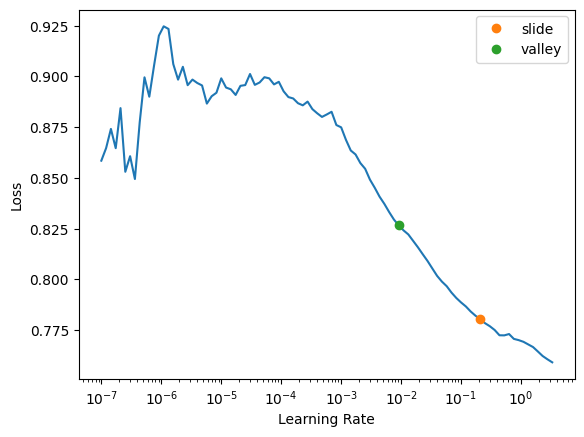

In [144]:
learn.lr_find(suggest_funcs=[slide, valley])

In [145]:
# got 83% accuracy on validation set vs 80% in deep learning cnn lecture
learn.fit_one_cycle(30, lr_max=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.699043,0.680698,0.554375,00:05
1,0.683000,0.677610,0.575625,00:05
2,0.683879,0.688934,0.555000,00:05
3,0.663886,0.686316,0.593125,00:05
4,0.659313,0.701528,0.554375,00:05
5,0.647951,0.714761,0.557500,00:05
6,0.621391,0.665594,0.599375,00:05
7,0.624113,0.621312,0.661250,00:05
8,0.606645,0.598053,0.682500,00:05
9,0.595207,0.729203,0.556875,00:05
